In [1]:
# for data
from statsmodels.graphics.api import abline_plot
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical tests
import scipy
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, linear_model, metrics

# for model persistence
import pickle

# for files
import os.path

# for date
import datetime

# for HTTP
import requests

# for weather
import meteostat as met
from geopy.geocoders import Nominatim

# for dataframe nesting
from weatherData import WeatherData 

# show not only last output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [16]:
geolocator = Nominatim(user_agent="hke-tgki/0.1")

def isWorkDay(datestring):
    freeDays =  ["Saturday", "Sunday"]
    return not (datetime.datetime.strptime(datestring, "%Y-%m-%d").strftime("%A") in freeDays)

def isTravellingDate(date):
    travellingDates = getTravellingDates(datetime.datetime.strptime(date, "%Y-%m-%d").year)
    return date in travellingDates

def get_weather_for_date_and_point(date, point, desired_data = ['tmax', 'prcp']):
    weather_data = met.Daily(point, date, date).fetch()
    weather_dict = {}
    if(weather_data.empty): return None
    for data_col in desired_data:
        weather_dict[data_col] = weather_data.iloc[0][data_col]

    return weather_dict

def getPredictionDataStructure(numberOfRows):
    # Load csv with data structure
    dataFileName ="../data/mobilityData_complete.csv"
    if os.path.isfile(dataFileName):
        dtf = pd.read_csv(dataFileName)
    else:
        print("Data file could not be loaded")
        return

    # Extract column names from data structure
    doWColumns = [col for col in dtf if col.startswith('DoW_')]
    dayColumns = [col for col in dtf if col.startswith('Day_')]
    weatherColumns = ["MaxTemp", "Precip"]
    endIdColumns = [col for col in dtf if col.startswith('EndId_')]
    columns = doWColumns + dayColumns + endIdColumns + weatherColumns

    # Create dtf with n rows
    data = np.array([np.zeros(numberOfRows, dtype=np.int32)]*columns.__len__()).T

    dtf = pd.DataFrame(data, columns=columns)
    dtf.fillna(0)

    return dtf

def getReturnDataStructure(numberOfRows):
    cols = ["Date", "DistrictId", "DistrictName", "MaxTemp", "Precip", "Visitors"]
    # Create dtf with single row
    data = np.array([np.zeros(numberOfRows, dtype=np.int32)]*cols.__len__()).T
    return pd.DataFrame(data, columns=cols)

def getDatesToPredict(startDate, endDate):
    now = datetime.datetime.today()
    startDate = datetime.datetime.strptime(startDate, "%Y-%m-%d")
    endDate = datetime.datetime.strptime(endDate, "%Y-%m-%d")

    intoFuture = endDate - now
    if(intoFuture.days > 10):
        print("Preditions more than 10 days into the future are too unreliable")
        return

    delta = endDate - startDate

    datestrings = []

    for i in range(delta.days + 1):
        day = startDate + datetime.timedelta(days=i)
        datestrings.append(day.strftime("%Y-%m-%d"))

    return datestrings

def getSavedDistricts():
     # Load districts
    districtsFileName = "../data/districts.csv"
    if os.path.isfile(districtsFileName):
        # load saved model
        return pd.read_csv("../data/districts.csv")
    else:
        print("No saved districts could be loaded")
        return None

def addPredictionDataset(dtf, predictions, districts, districtId, date, datasetIndex=0):
    predictions.loc[datasetIndex, 'Date'] = date
    predictions.loc[datasetIndex, 'DistrictId'] = districtId
    predictions.loc[datasetIndex, 'DistrictName'] = districts.loc[(districts.EndId == districtId), 'EndName'].values[0]

    # Fill in EndId and date values
    endIdColumn = 'EndId_' + str(districtId)
    dtf.loc[datasetIndex, endIdColumn] = 1
    
    # Generate datetime object from passed date
    dateObject = datetime.datetime.strptime(date, "%Y-%m-%d")

    # Fill in DoW type  
    dtf.loc[datasetIndex, "DoW_" + dateObject.strftime("%A")] = 1

    # Fill in Day_class_work
    dtf.loc[datasetIndex, "Day_class_work"] = int(isWorkDay(date))

    # Fill in Day_class_travel type
    dtf.loc[datasetIndex, "Day_class_travel"] = int(isTravellingDate(date))

    # print(dtf[["MaxTemp", "Precip"]].head())

    # Get and add weather data
    weatherData = get_weather_for_date_and_point(dateObject, met.Point(districts.loc[(districts.EndId == districtId), 'Lat'].values[0], districts.loc[(districts.EndId == districtId), 'Lon'].values[0]))
    if(weatherData == None): return dtf, predictions
    dtf.loc[datasetIndex, "MaxTemp"] = weatherData["tmax"]
    dtf.loc[datasetIndex, "Precip"] = weatherData["prcp"]
    predictions.loc[datasetIndex, 'MaxTemp'] = weatherData["tmax"]
    predictions.loc[datasetIndex, "Precip"] = weatherData["prcp"]

    return dtf, predictions

def predict(dtf):
    modelFileName = "mobilityPredictionModel.sav"
    if os.path.isfile(modelFileName):
        # load saved model
        model = pickle.load(open(modelFileName, 'rb'))
    else:
        print("No saved model could be loaded")
        return

    return np.int32(np.round(model.predict(dtf.values), decimals=0))
    
def singlePredict(districtId, date):
    dtf = getPredictionDataStructure(1)
    predictions = getReturnDataStructure(1)
    districts = getSavedDistricts()
    if(districts.empty): return
    dtf, predictions = addPredictionDataset(dtf, predictions, districts, districtId, date)
    predictions['Visitors'] = predict(dtf)
    return predictions

def multiPredict(districtIds, startdate, enddate):
    districts = getSavedDistricts()
    if(districts.empty): return
    dates = getDatesToPredict(startdate, enddate)
    predictions = getReturnDataStructure(len(districtIds)*len(dates))
    dtf = getPredictionDataStructure(len(districtIds)*len(dates))
    for i, districtId in enumerate(districtIds):
        for j, date in enumerate(dates):
            dtf, predictions = addPredictionDataset(dtf, predictions, districts, districtId, date, i*len(dates)+j)
    predictions['Visitors'] = predict(dtf)
    return predictions


## Daten einlesen
Daten werden aus `.csv`-Datei eingelesen.

In [4]:
dtf = pd.read_csv("../data/mobilityData.csv")

## Spalten selektieren
Nur die für den weiteren Prozess relevanten Spalten werden beibehalten.

In [ ]:
dtf.columns = dtf.columns.str.strip()
cols = ["Bucket", "StartId", "StartName", "EndId", "EndName", "Count"]
dtf = dtf[cols]

## Besucherzahlen aggregieren
Besucherströme, welche am selben Tag in den selben Ziellandkreis erfolgen, werden zusammengefasst.

In [ ]:
dtf = dtf[dtf['Bucket'].str.len() == 10]
dtf = dtf.groupby(["Bucket", "EndId", "EndName"])[
    "Count"].sum().reset_index()

## Wochentage hinzufügen
Der entsprechende Wochentag jedes einzelnen Datensatzes wird hinzugefügt.

In [ ]:
dtf["DoW"] = dtf["Bucket"].apply(
    lambda bucket: pd.to_datetime(bucket).day_name())

## Zeitraum begrenzen
Aufgrund von nicht zu berücksichtigenden Abweichungen im Mobilitätsverhalten, welche durch die Corona-Maßnahmen im Jahr 2020 hervorgerufen wurden, werden für das Training lediglich die Datensätze ab dem 01.04.2020 verwendet.

In [ ]:
dtf = dtf[dtf['Bucket'] >= '2020-04-01']

## Nomenklatur anpassen
Die "Zielspalte" (`Count` = Besucheranzahl) wird gemäß der gängigen Nomenklatur im Machine Learning Kontext in `Y` umbenannt.

In [ ]:
dtf = dtf.rename(columns={"Count": "Y"})

## Landkreise extrahieren
Aus den bestehenden Daten werden alle auftretenden Ziellandkreise extrahiert.

In [ ]:
districts = dtf[['EndId', 'EndName']].copy()
districts.drop_duplicates(subset = ["EndId"], inplace=True)

## Landkreiskoordinaten ermitteln
Für jeden extrahierten Landkreis werden über die `geopy`-Bibliothek (siehe `Doku_developer external_data.md`) Koordinaten basierend auf dem Landkreisnamen ermittelt. Landkreisnamen, für die keine Koordinaten ermittelt werden können werden in einer Fehlermeldung genannt und der Datensatz übersprungen.

In [ ]:
districts["Lat"] = ""
districts["Lon"] = ""

for i in districts.index:
    location = geolocator.geocode(districts['EndName'][i])
    
    if (location == None):
        print("Could not find coordinates for district: " + districts['EndName'][i])

    if (location.latitude == None or location.longitude == None): continue

    districts.loc[i,'Lat'] = location.latitude
    districts.loc[i,'Lon'] = location.longitude

## Landkreisdaten speichern
Alle ermittelten Landkreisdaten werden in einer `.csv`-Datei gespeichert, um bei einem späteren Training oder eine Prognose darauf zugreifen zu können.

In [6]:
districts.to_csv("../data/districts.csv")

Rostock - Ortsbeirat 18 : Gehlsdrf,Hinrichsdorf,Jürgenshof,Krummendorf,Nienhagen,Peez,Stuthof


## Wetterdaten für Landkreise laden
Für jeden Landkreis werden vom Datum des ersten Datensatzes bis zum Datum des letzten Datensatzes der Mobilitätsdaten die entsprechenden Wetterdaten für den Landkreis abgefragt (siehe `Doku_developer external_data.md`) und im `districts`-Dataframe zwischengespeichert.
Dies passiert aus Gründen der Performanz, da es performanter ist, wenige Anfragen für jeweils größere Zeiträume zu tätigen (eine Anfrage pro Landkreis für gesamten Zeitraum) als viele Anfragen für jeweils nur einen Tag (einzelne Anfragen für jeden Datensatz, sprich für jede Tag-Landkreis-Kombination in den Mobilitätsdaten).

In [7]:
districts["Weather"] = ""
start = datetime.datetime.strptime(dtf.iloc[1]['Bucket'], "%Y-%m-%d")
end = datetime.datetime.strptime(dtf.iloc[-1]['Bucket'], "%Y-%m-%d")

for i in districts.index:
    districts.loc[i,'Weather'] = WeatherData(met.Daily(met.Point(districts['Lat'][i], districts['Lon'][i]), start, end).fetch())

,Unnamed: 0,EndId,EndName,Lat,Lon,Weather
0,34472,2701700,Rendsburg-Eckernförde,54.327870,9.720589,NaN
1,34473,6233900,Saale-Orla-Kreis,50.586455,11.776174,NaN
2,34474,6234000,Baden-Baden,48.758078,8.241524,NaN
3,34475,6234300,Rheinisch-Bergischer Kreis,51.014037,7.171613,NaN
4,34476,6234400,Rottweil - Landkreis Rottweil,48.165531,8.625128,NaN


## Wetterdaten für alle Mobilitätsdatensätze hinzufügen
Für jeden Mobilitätsdatensatz im `dtf`-Dataframe werden nun die entsprechenden Wetterdaten für Tag und Landkreis herausgesucht, welche im vorangegangenen Schritt im `districts`-Dataframe gespeichert wurden. Diese Wetterdaten werden direkt zum entsprechenden Mobilitätsdatensatz hinzugefügt.
In diesem Fall handelt es sich um zwei Wetterkennzahlen: `MaxTemp` = Höchsttemperatur in °C, `Precip` = Niederschlagsmenge in mm

In [8]:
dtf["MaxTemp"] = ""
dtf["Precip"] = ""

for i in dtf.index:
    id = dtf.loc[i, 'EndId']
    time = dtf.loc[i, 'Bucket']
    weatherData = districts.loc[(districts.EndId == id),'Weather'].values[0]

    if(weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time))].size < 1):
        continue

    dtf.loc[i, 'MaxTemp'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'tmax'].values[0]
    dtf.loc[i, 'Precip'] = weatherData.data.loc[(weatherData.data.index == pd.Timestamp(time)), 'prcp'].values[0]

,Bucket,EndId,EndName,Y,DoW,MaxTemp,Precip
34472,2020-04-01,2701700,Rendsburg-Eckernförde,7,Wednesday,8.4,0.2
34473,2020-04-01,6233900,Saale-Orla-Kreis,32,Wednesday,7.5,0.0
34474,2020-04-01,6234000,Baden-Baden,7,Wednesday,11.6,0.0
34475,2020-04-01,6234300,Rheinisch-Bergischer Kreis,7,Wednesday,11.7,0.0
34476,2020-04-01,6234400,Rottweil - Landkreis Rottweil,67,Wednesday,10.1,0.0


## Ungültige Datensätze entfernen
Alle jetzt im `dtf`-Dataframe enthaltenen Mobilitätsdatensätze, welche in mindestens einer Spalte ungültige Werte beinhalten werden in diesem Schritt entfernt.

In [10]:
# Remove invalid values
print("Rows before NaN removal: ", dtf.shape[0])
dtf.replace([np.inf, -np.inf], np.NaN, inplace=True)
dtf.replace("", np.NaN, inplace=True)
dtf.dropna(how='any', axis=0, inplace=True)
print("Rows after NaN removal: ",dtf.shape[0])

Rows before NaN removal:  95418
Rows after NaN removal:  94654


## Tage klassifizieren
Gemäß des jeweiligen Wochentags bekommt jeder Datensatz in einer zusätzlichen Spalte `Day_class` den Wert `free` (Samstag, Sonntag) oder `work` (Montag, Dienstag, Mittwoch, Donnerstag, Freitag) zugewiesen.

In [ ]:
Day_clusters = {"free": ["Saturday", "Sunday"], "work": ["Monday", "Tuesday", "Wednesday",
                                                         "Thursday", "Friday"]}

dic_flat = {v: k for k, lst in Day_clusters.items() for v in lst}

for k, v in Day_clusters.items():
    if len(v) == 0:
        residual_class = k
        
dtf["Day_class"] = dtf['DoW'].apply(lambda x: dic_flat[x] if x in
                                   dic_flat.keys() else residual_class)

## Feiertage laden
Feiertage für das Jahr des ersten Mobilitätsdatensatzes werden über HTTPS-Request geladen (siehe `Doku_developer external_data.md`) und die entsprechenden Daten der Feiertage extrahiert.

In [ ]:
year = dtf['Bucket'].iloc[0][:4]

# Request free days from Feiertage API for year 2021 in bavaria
free_days_json = requests.get(
    f'https://feiertage-api.de/api/?jahr={year}&nur_land=BY')

# Parse result and store as [key, val] dict
free_days_json = free_days_json.json()

free_days = []

# Iterate over
for free_day_name in free_days:
    free_days.append(free_days_json[free_day_name]['datum'])

## Feiertage in Klassifikation aufnehmen
Für alle Daten, die zuvor als Feiertage ermittelt wurden, wird die Klassifikation in der Spalte `Day_class` auf `free` geändert.

In [ ]:
for day in free_days:
    dtf.loc[(dtf.Bucket == day), 'Day_class'] = 'free'

## Ferienzeiträume laden
Ferienzeiträume für das Jahr des ersten Mobilitätsdatensatzes werden über HTTPS-Request geladen (siehe `Doku_developer external_data.md`). Gespeichert wird hierbei jeweils das Datum des ersten und letzten Ferientags.

In [ ]:
year = dtf['Bucket'].iloc[0][:4]

# Request free days from Feiertage API for year in bavaria
holidays = requests.get(
f'https://ferien-api.de/api/v1/holidays/BY/{year}')

# Parse result and store as [key, val] dict
holidays = holidays.json()

holiday_dates = []

# Iterate over
for holiday in holidays:
    holiday_dates.append((holiday['start'], holiday['end']))

## Reisetage identifizieren
Ausgehend von den angefragten Ferienzeiträumen werden nun die entsprechenden Reisetage ermittelt. Hierbei werden jeweils die ersten x Tage ab dem ersten Ferientag (`start + timespan`) sowie die letzten x Tage vor dem letzten Ferientag (`end - timespan`) als Reisetage betrachtet und die entsprechenden Daten ermittelt.

In [ ]:
timespan = 4

travellingDays = []

for date in holiday_dates:
    start = datetime.datetime.strptime(date[0], "%Y-%m-%dT%H:%MZ")
    end = datetime.datetime.strptime(date[1], "%Y-%m-%dT%H:%MZ")
    for i in range(0, timespan-1, 1):
        travellingDays.append(datetime.datetime.strftime(start + datetime.timedelta(days=i), "%Y-%m-%d"))
        travellingDays.append(datetime.datetime.strftime(end - datetime.timedelta(days=i),"%Y-%m-%d" ))

## Reisetage in Klassifikation aufnehmen
Es wird eine neue Spalte `Day_class_travel` angelegt, deren Werte für alle Datensätze deren Datum in `travellingDays` enthalten ist `= 1` gesetzt wird (sonst `= 0`).

In [ ]:
dtf['Day_class_travel'] = 0
for day in travellingDays:
    dtf.loc[(dtf.Bucket == day), 'Day_class_travel'] = 1

## One-Hot-Encoding
Spalten, welche qualitative Werte enthalten (`Day_class, DoW, EndId`) werden im Folgenden One-Hot-Encodiert.

In [ ]:
# create dummies Day_class
dummy = pd.get_dummies(dtf["Day_class"],
                       prefix="Day_class", drop_first=True)
dtf = pd.concat([dtf, dummy], axis=1)
    
# drop the original column
dtf = dtf.drop("Day_class", axis=1)


# create dummies DoW
dummy = pd.get_dummies(dtf["DoW"],
                       prefix="DoW", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)

# drop the original column
dtf = dtf.drop("DoW", axis=1)


# create dummies EndId
dummy = pd.get_dummies(dtf["EndId"],
                       prefix="EndId", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)


## Aufbereitete Daten speichern
Die fertig aufbereiteten Daten werden als `.csv` gespeichert, um sie für zukünftige Trainingsdurchgänge oder als Vorlage für die Datenstruktur im Falle einer Prognose verfügbar zu haben.

In [19]:
dtf.to_csv("../data/mobilityData_complete.csv")

## Daten auf relevante Features reduzieren
In diesem Schritt werden die für den Lernprozess relevanten Spalten ("Features") festgelegt und die Daten auf diese Features reduziert.

In [ ]:
# define training and test features
DoWColumns = [col for col in dtf if col.startswith('DoW_')]
DayColumns = [col for col in dtf if col.startswith('Day_')]
WeatherColumns = ["MaxTemp", "Precip"]
EndIdColumns = [col for col in dtf if col.startswith('EndId_')]
X_names = DoWColumns + DayColumns + EndIdColumns + WeatherColumns

relevantDtf = dtf[X_names + ["Y"]]

## Aufteilung Training & Test
Die Daten der relevanten Features werden in Trainings- (80%) und Testdaten (20%) unterteilt.

In [21]:
# split data
dtfTrain, dtfTest = model_selection.train_test_split(relevantDtf,
                                                     test_size=0.2)

## Trennung Features & Y
Die Features werden von den später zu prognostizierenden Besucherzahlen (`Y`) getrennt.

In [ ]:
X_train = dtfTrain[X_names].values
Y_train = dtfTrain["Y"].values

X_test = dtfTest[X_names].values
Y_test = dtfTest["Y"].values

## Model festlegen
Als zu verwendendes Model wird der `GradientBoostingRegressor` der Bibliothek `Scikit learn` mit den durch Testläufe ermittelten besten Parametern festgelegt.

In [26]:
model = ensemble.GradientBoostingRegressor(n_estimators=400, random_state=21)

    

GradientBoostingRegressor(n_estimators=400, random_state=21)

## Training
Das Model wird anhand der Trainingsdaten trainiert.

In [ ]:
model.fit(X_train, Y_train)

## Model speichern
Um in Zukunft auf des fertig trainierte Model zurückzugreifen zu können (bspw. für die Erstellung einer Prognose) wird dieses in einer Datei gespeichert.

In [ ]:
pickle.dump(model, open("mobilityPredictionModel.sav", 'wb'))

## Testprognose
Anhand der Features der Testdaten (welche **nicht** zum Training des Models verwendet wurden) werden vom Model entsprechende Besucherzahlen für diese Features prognostiziert.

In [27]:
predicted = model.predict(X_test)

## Testprognosenkennzahlen
Hier werden verschiedene Kennzahlen zur Testprognose abgegeben, welche Aufschluss darüber geben können, wie stark die prognostizierten Besucherzahlen von den realen abweichen.

Mean Absolute Error (Σ|y-pred|/n): 961
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 7,787
95-percentile Mean Absolute Error: 164
Max Error: -246,916
Max Error Dataset:
           Bucket    EndId       Y
12215  2020-05-23  6241500  411110


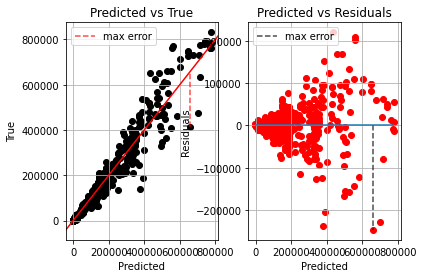

In [29]:
# Print errors
print("Mean Absolute Error (Σ|y-pred|/n):",
        "{:,.0f}".format(metrics.mean_absolute_error(Y_test, predicted)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
        "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(Y_test, predicted))))

# Print residuals
residuals = Y_test - predicted
max_error = max(residuals) if abs(max(residuals)) > abs(
    min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(
    min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = Y_test[max_idx], predicted[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))


# Get dataset that has biggest error
max_difference_y = 0
max_dif = 0
for idx, val in enumerate(Y_test):
    dif = abs(val - predicted[idx])
    if(dif > max_dif):
        max_dif = dif
        max_difference_y = val
print("Max Error Dataset:")
print(dtf.loc[dtf['Y'] == max_difference_y, ["Bucket", "EndId", "Y"]])


# Plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(predicted, Y_test, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error,
                color='red', linestyle='--', alpha=0.7, label="max error")
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()

# Plot predicted vs residuals
ax[1].scatter(predicted, residuals, color="red")
ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black',
                linestyle='--', alpha=0.7, label="max error")
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals",
            title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
ax[1].legend()
plt.show()

In [30]:
singlePredict(6241500, "2021-05-15").head()     
singlePredict(6241500, "2021-07-22").head()       
singlePredict(6241500, "2021-08-20").head()       
singlePredict(6241500, "2021-09-02").head()

,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-05-15,6241500,Oberallgäu - Landkreis Oberallgäu,11,13.1,410757


,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-07-22,6241500,Oberallgäu - Landkreis Oberallgäu,22.4,0,667512


,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-08-20,6241500,Oberallgäu - Landkreis Oberallgäu,19.7,0,480033


,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-09-02,6241500,Oberallgäu - Landkreis Oberallgäu,19.2,0,458894


In [31]:
# Oberallgäu    6241500
# Kempten       6270100
# Memmingen     6259000

multiPredict([6241500, 6270100, 6259000], "2021-12-23", "2021-12-26").head(21)

,Date,DistrictId,DistrictName,MaxTemp,Precip,Visitors
0,2021-12-23,6241500,Oberallgäu - Landkreis Oberallgäu,4.0,0.0,388354
1,2021-12-24,6241500,Oberallgäu - Landkreis Oberallgäu,5.3,7.0,373428
2,2021-12-25,6241500,Oberallgäu - Landkreis Oberallgäu,4.6,14.1,386653
3,2021-12-26,6241500,Oberallgäu - Landkreis Oberallgäu,3.0,6.7,291772
4,2021-12-23,6270100,Kempten (Allgäu),8.5,0.0,137147
5,2021-12-24,6270100,Kempten (Allgäu),7.7,6.2,128731
6,2021-12-25,6270100,Kempten (Allgäu),6.8,7.9,148687
7,2021-12-26,6270100,Kempten (Allgäu),5.5,2.0,111151
8,2021-12-23,6259000,Memmingen,6.6,0.0,98878
9,2021-12-24,6259000,Memmingen,6.5,4.1,95077
